# The classification task

This is where all things come together, where the actual classification task is carried out.

In [3]:
# define a logger
import logging
logging.getLogger().setLevel(logging.INFO)

## Utility functions

In [4]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [5]:
# Read model from disk
from gensim.models import Doc2Vec
import os

def loadModel(dim=600):
    if(dim not in (100, 300, 600)):
        raise ValueError('dim must be 100, 300 or 600')
        
    modelName = 'allDocs' + str(dim) + 'D.model'
    modelBasePath = 'cache'
    modelPath = os.path.join(os.getcwd(), modelBasePath, modelName)

    logging.info('start loading the model')
    model = Doc2Vec.load(modelPath)
    logging.info('loading completed')
    return model

INFO:gensim.utils:Pattern library is not installed, lemmatization won't be available.
INFO:summa.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [6]:
# compile the corpus
import os
import json
from tqdm import tqdm
import numpy as np

def loadData(model=None, regression=False):
    JSONFILESDIR = 'data/json'
    X = []
    y = []
    
    if regression:
        zero = np.array([0,1], dtype=np.int32)
        one = np.array([1,0], dtype=np.int32)
    else:
        zero = np.int32(0)
        one = np.int32(1)

    logging.info('building corpus...')
    filenames = model.docvecs.doctags.keys()
    for k in tqdm(filenames):
        with open(os.path.join(JSONFILESDIR, k + '.json')) as fh:
            jsonFile = json.load(fh)

        if jsonFile['lang'] != 'en' or jsonFile['citedBy'] is None:
            logging.debug('{f} discarded from corpus.'.format(f=k))
            continue

        X.append(model.docvecs[k])
        isSuccessfull = one if int(jsonFile['citedBy']) > 0 else zero
        y.append(isSuccessfull)
        logging.debug('{f} absorbed into corpus.'.format(f=k))

    # transform to numpy arrays
    X = np.array(X)
    y = np.array(y)

    logging.info('corpus complete')
    return X, y

In [7]:
# classifying neural net
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from lasagne.nonlinearities import rectify, tanh, softmax, sigmoid

def makeLayers(depth=3):
    yield ('input', layers.InputLayer)
    yield ('hidden0', layers.DenseLayer)
    for i in range(1, depth - 2):
        yield ('dropout' + str(i-1), layers.DropoutLayer)
        yield ('hidden' + str(i), layers.DenseLayer)
    yield ('output', layers.DenseLayer)
    
def makeParameters(arch, dropout_p, nonlinearity):
    if len(arch) < 3:
        raise ValueError("The network must be at least 3 layers deep")
    depth = len(arch)
    params = {}
    
    # the static ones
    exec('params["{}"] = ({}, {})'.format('input_shape', "None", arch[0]))
    exec('params["{}"] = {}'.format('hidden0_num_units', arch[1]))
    for i in range(1, depth - 2):
        exec('params["{}"] = {}'.format('dropout' + str(i-1) + '_p', dropout_p))
        exec('params["{}"] = {}'.format('hidden' + str(i) + '_num_units', arch[i+1]))
    
    # again some statics ones
    exec('params["{}"] = {}'.format('output_num_units', arch[-1]))
    exec('params["{}"] = {}'.format('output_nonlinearity', nonlinearity))
    return params

def loadNN(arch=(100, 400, 160, 2), dropout_p=0.6, epochs=50,\
           nonlinearity=None, regression=False, evalSize=.1):
    if not regression and nonlinearity != 'softmax':
        nonlinearity = 'softmax'
        logging.info("nonlinearity was set to 'softmax'. This is\
            the only non-linearity supported by classification")
        
    return NeuralNet(
        # configuration
        layers=[x for x in makeLayers(len(arch))],
        **makeParameters(arch, dropout_p, nonlinearity),
        
        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,

        regression=regression,
        max_epochs=epochs,
        eval_size=evalSize,
        verbose=1,
        on_epoch_finished=[EarlyStopping(patience=10)]
        )

/home/user/projekte/anaconda3/envs/ipynb/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [8]:
# NN creating factory
from sklearn.cross_validation import train_test_split
from collections import namedtuple
import numpy as np
from sklearn import svm
from sklearn.neighbors.nearest_centroid import NearestCentroid

TrainTestData = namedtuple("TrainTest", ["X_train","X_test","y_train","y_test"])

try:
    model
except NameError:
    model = {}

try:
    X
    y
except NameError:
    X, y = {}, {}

# returns the matrix X and the vector y.
# they can be used for fitting a model
def loadXy(inputDim = 600, regression=False):
    # get the persisted model, including the training
    # data associated with it. check if already loaded
    global model
    global X, y
    # if currently loaded data doesn't match the requested dimensionality
    if type(X) == np.ndarray and X.shape[1] != inputDim:
        model, X, y = {}, {}, {}
    if model == {}:
        model = loadModel(inputDim)
    
    # give the data in a convenient format
    if any([type(X) != np.ndarray, type(y) != np.ndarray]):
        X, y = loadData(model=model, regression=regression)
    return X, y

def genSVNclf(inputDim=600, evalSize=.1):
    clf = svm.SVC()
    X, y = loadXy(inputDim=inputDim, regression=False)
    # carry out train/test split
    X_train, X_test, y_train, y_test = train_test_split( \
        X, y, test_size=evalSize, random_state=42)
    clf.fit(X_train, y_train)
    return clf, TrainTestData(X_train, X_test, y_train, y_test)

def genKNNclf(inputDim, evalSize=.1):
    clf = NearestCentroid()
    X, y = loadXy(inputDim=inputDim, regression=False)
    # carry out train/test split
    X_train, X_test, y_train, y_test = train_test_split( \
        X, y, test_size=evalSize, random_state=42)
    clf.fit(X_train, y_train)
    return clf, TrainTestData(X_train, X_test, y_train, y_test)

# returns a trained network and the corresponding training
# and test data
def genNNclf(inputDim=600, regression=False, arch=(400, 160, 2), \
            dropout_p=.6, epochs=100, nonlinearity='softmax', \
            evalSize=.1):

    X, y = loadXy(inputDim=inputDim, regression=regression)
    # add input layer to NN's arch
    myArch = list(arch)
    myArch.insert(0, inputDim)
    
    # instanciate the network
    net = loadNN(arch=myArch, dropout_p=dropout_p, epochs=epochs, \
                 nonlinearity=nonlinearity, regression=regression,
                 evalSize=evalSize)
    # carry out train/test split
    X_train, X_test, y_train, y_test = train_test_split( \
        X, y, test_size=evalSize, random_state=42)
    
    # train the network
    net.fit(X_train, y_train)
    
    return net, TrainTestData(X_train, X_test, y_train, y_test)

In [9]:
NNCandidate = namedtuple('NNCandidate', \
                         ['inputDim', 'dropout', 'arch', 'evalRes'])
EvalResults = namedtuple('EvalResults', ['All','Pos','Neg', 'SuccRate', 
                         'TrainLoss', 'ValidLoss'])
NNcandidatesPath = os.path.join('cache', 'NNcandidates')

In [10]:
from collections import namedtuple
from nolearn.lasagne import NeuralNet

def evalPrediction(clf, trainTestData, regression=False):
    # predict the test set
    predictions = clf.predict(trainTestData.X_test)
    predictions = predictions.round().astype(np.int32)
    
    # dealing with the different data representations 
    # of regression vs classification
    if regression:
        truthMatrix = trainTestData.y_test[:, 0] == predictions[:, 0]
        positiveTestCases = trainTestData.y_test[:, 0].sum()
    else:
        truthMatrix = trainTestData.y_test == predictions
        positiveTestCases = trainTestData.y_test.sum()

    testSize = truthMatrix.shape[0]
    correct = truthMatrix.sum()
    false = testSize - truthMatrix.sum()
    if isinstance(clf, NeuralNet):
        train_loss = np.array([i["train_loss"] for i in net.train_history_])
        valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    else:
        train_loss = ""
        valid_loss = ""
    
    return EvalResults(testSize, correct, false, correct/float(testSize),\
                       train_loss, valid_loss)

In [ ]:
# automated nn testing
from collections import namedtuple
import pickle
import os

# predefined network architectures
archs = ((100, 2), (300, 2), (250, 80, 2), (500, 160, 2), (400, 150, 40, 2))

for inputDim in (100, 300, 600):
    for dropout in (.4, .6):
        for arch in archs:
            net, trainTestData = genNNclf(inputDim=inputDim, arch=arch, dropout_p=dropout, regression=True)
            evalRes = evalPrediction(net, trainTestData)
            candidate = NNCandidate(inputDim, dropout, arch, evalRes)
            with open(NNcandidatesPath, str(inputDim) + str(dropout) + str(arch) + '.pickle', 'wb') as fh:
                pickle.dump(candidate, fh)

In [ ]:
# pick the best performing NN
import os
import pickle
from collections import namedtuple

results = []

for i, p in enumerate(os.listdir(NNcandidatesPath)):
    with open(os.path.join(NNcandidatesPath, p), 'rb') as fh:
        candidate = pickle.load(fh)
    results.append(candidate)
    
results = sorted(results, key=lambda x: x.evalRes.SuccRate)
results[-21]

In [ ]:
# playing with regression, rather than classification
inputDim=600
arch=(500, 160, 2)
dropout_p=.6
regression=False

net, trainTestData = genNNclf(inputDim=inputDim, arch=arch, dropout_p=dropout_p, regression=regression)
evalRes = evalPrediction(net, trainTestData)
candidate = NNCandidate(inputDim, dropout_p, arch, evalRes)

In [ ]:
# let's try a SVM
clf, trainTestData = genSVNclf(inputDim=600)
evalRes = evalPrediction(clf, trainTestData)
print('SVM success rate: {}'.format(evalRes.SuccRate))

In [12]:
# and finally a kNN
clf, trainTestData = genKNNclf(inputDim=600)
evalRes = evalPrediction(clf, trainTestData)
print('kNN success rate: {}'.format(evalRes.SuccRate))

kNN success rate: 0.6298963639557351


In [13]:
# visualize the training progress
%pylab inline
import matplotlib.pyplot as plt

#train_loss = np.array([i["train_loss"] for i in net.train_history_])
#valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
train_loss = results[-20].evalRes.TrainLoss
valid_loss = results[-20].evalRes.ValidLoss

marginFactor = 1.2
train_min = min(train_loss)
train_max = max(train_loss)
valid_min = min(valid_loss)
valid_max = max(valid_loss)
y_min = min(train_min, valid_min)
y_max = min(train_max, valid_max)

plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(y_min * 1/marginFactor, y_max * marginFactor)
plt.yscale("log")
plt.show()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


NameError: name 'results' is not defined

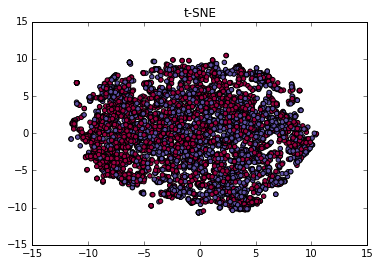

In [17]:
from sklearn import manifold, datasets

X, y = loadXy(inputDim=100, regression=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

try:
    x
except NameError:
    x = tsne.fit_transform(X_test)
    
plt.scatter(x[:, 0], x[:, 1], c=y_test, cmap=plt.cm.Spectral)
plt.title("t-SNE")

plt.show()